In [1]:
from foundry import Foundry
from skimage.io import imshow, imread
from keras_unet.models import custom_unet
import matplotlib.pyplot as plt
from keras_unet.utils import plot_imgs
import numpy as np
import cv2
import numpy as np
import tensorflow as tf
from keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

In [60]:
#need Globus to pull data
f = Foundry(search_index="mdf-test")
f = f.load('_test_foundry_stan_dendrite_segmentation_v1.1')
X,y = f.load_data()
X,y = X[0], y[0]

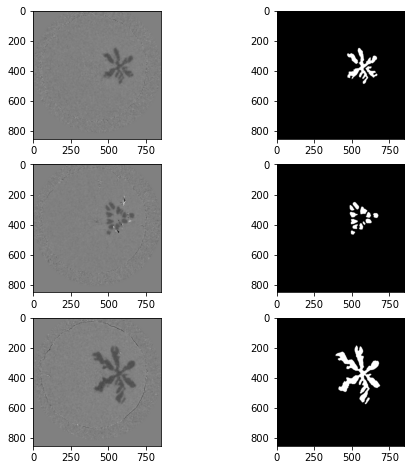

In [61]:
fig, axs = plt.subplots(3,2, figsize=(8,8))
for i in range(3):
    axs[i][0].imshow(X[i])
    axs[i][1].imshow(y[i])

# Build a Model to Predict 

# Resize to Match UNet
UNet requires images to be of a size multiple of 32

In [151]:
new_size = 32*10 # U-Net requires a multiple of 32

X_r = np.array([cv2.resize(img, dsize=(new_size, new_size)) 
     for img in X])
y_r = np.array([cv2.resize(mask, dsize=(new_size, new_size)) 
     for mask in y])

In [152]:
y_r.shape

(30, 320, 320, 3)

# Create UNet Model

In [153]:
input_shape = (new_size,new_size,3)

model = custom_unet(input_shape)

In [154]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 320, 320, 16) 432         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 320, 320, 16) 64          conv2d_38[0][0]                  
__________________________________________________________________________________________________
spatial_dropout2d_10 (SpatialDr (None, 320, 320, 16) 0           batch_normalization_36[0][0]     
____________________________________________________________________________________________

# Preview the Segmentation Task

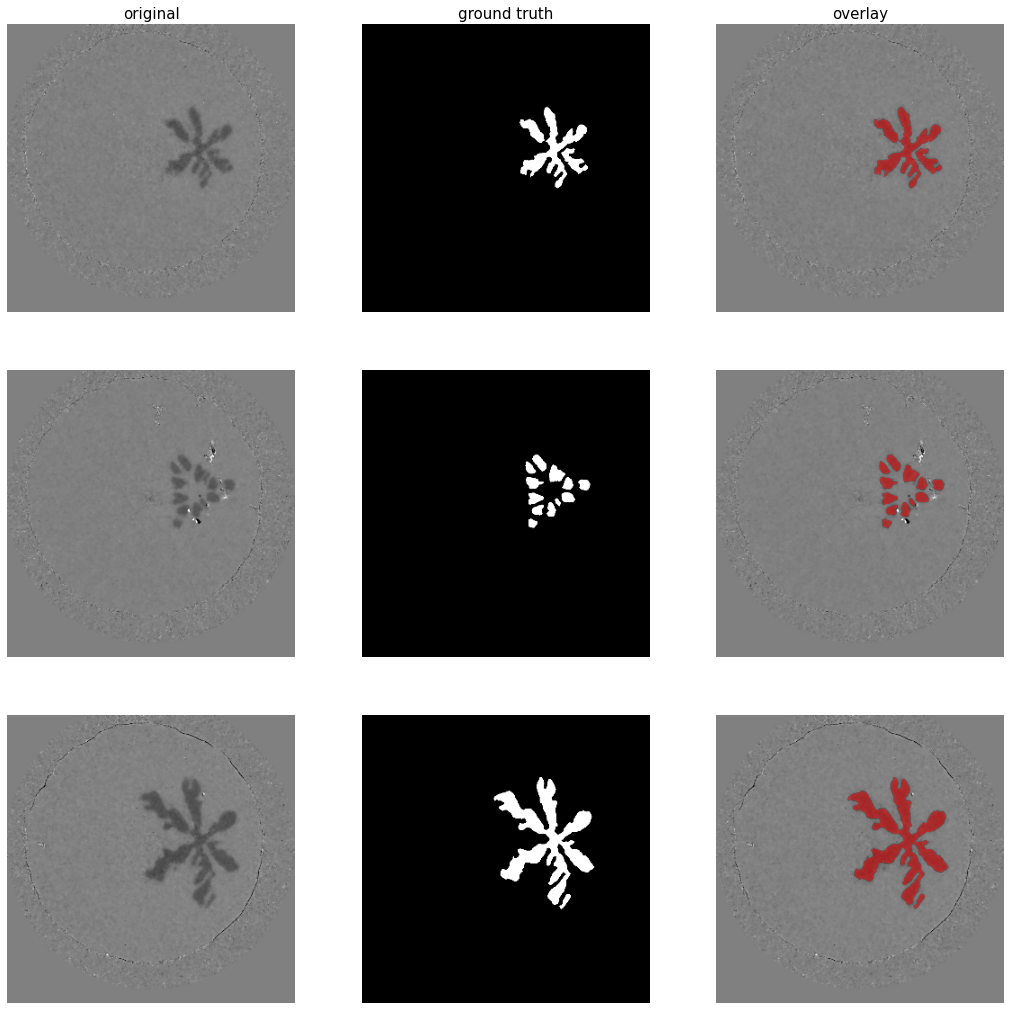

In [157]:
plot_imgs(org_imgs=X_r, mask_imgs=y_r[:,:,:,0], nm_img_to_plot=3, figsize=6)


# Create a Generator with Augmented Images

In [160]:
X_r.shape

(30, 320, 320, 3)

In [162]:
y_r.shape

(30, 320, 320, 3)

In [165]:
n_images = 30
y_c = y_r[:,:,:,0]

train_gen = get_augmented(
    X_r, np.reshape(y_c, (n_images, new_size, new_size, 1)), batch_size=2,
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=30,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

# Preview Augmented Images

(2, 320, 320, 3) (2, 320, 320, 1)


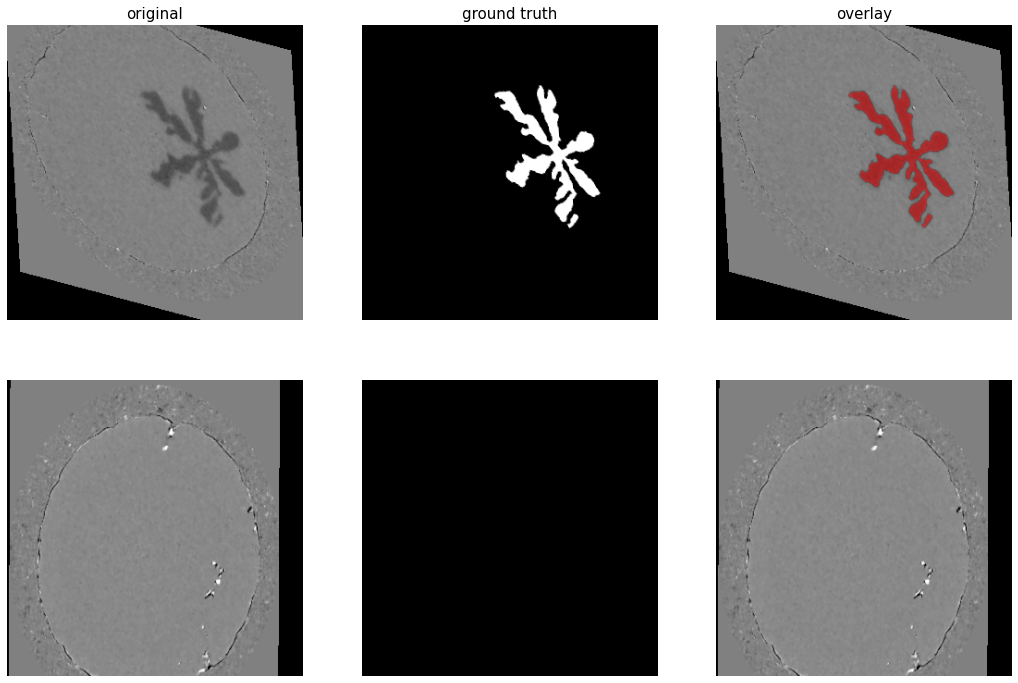

In [166]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy[:,:,:,0], nm_img_to_plot=2, figsize=6)

# Compile Model

In [167]:
model.compile(
    optimizer="adam", 
    #optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[tf.keras.metrics.MeanIoU(num_classes=2)]
)

# Fit Model

In [179]:
history = model.fit(
train_gen,
    steps_per_epoch=200,
    epochs=10
)

Epoch 1/2
200/200 [==============================] - 214s 1s/step - loss: 0.0160 - mean_io_u_2: 0.5600
Epoch 2/2
200/200 [==============================] - 224s 1s/step - loss: 0.0179 - mean_io_u_2: 0.5725


In [180]:
model.save(f"./{new_size}x{new_size}-model.h5") 

In [181]:
#model = tf.keras.models.load_model('./model_checkpoint.h5')

# Run Predict on Images

In [182]:
y_pred = model.predict(X_r)

# Check Performance Visually

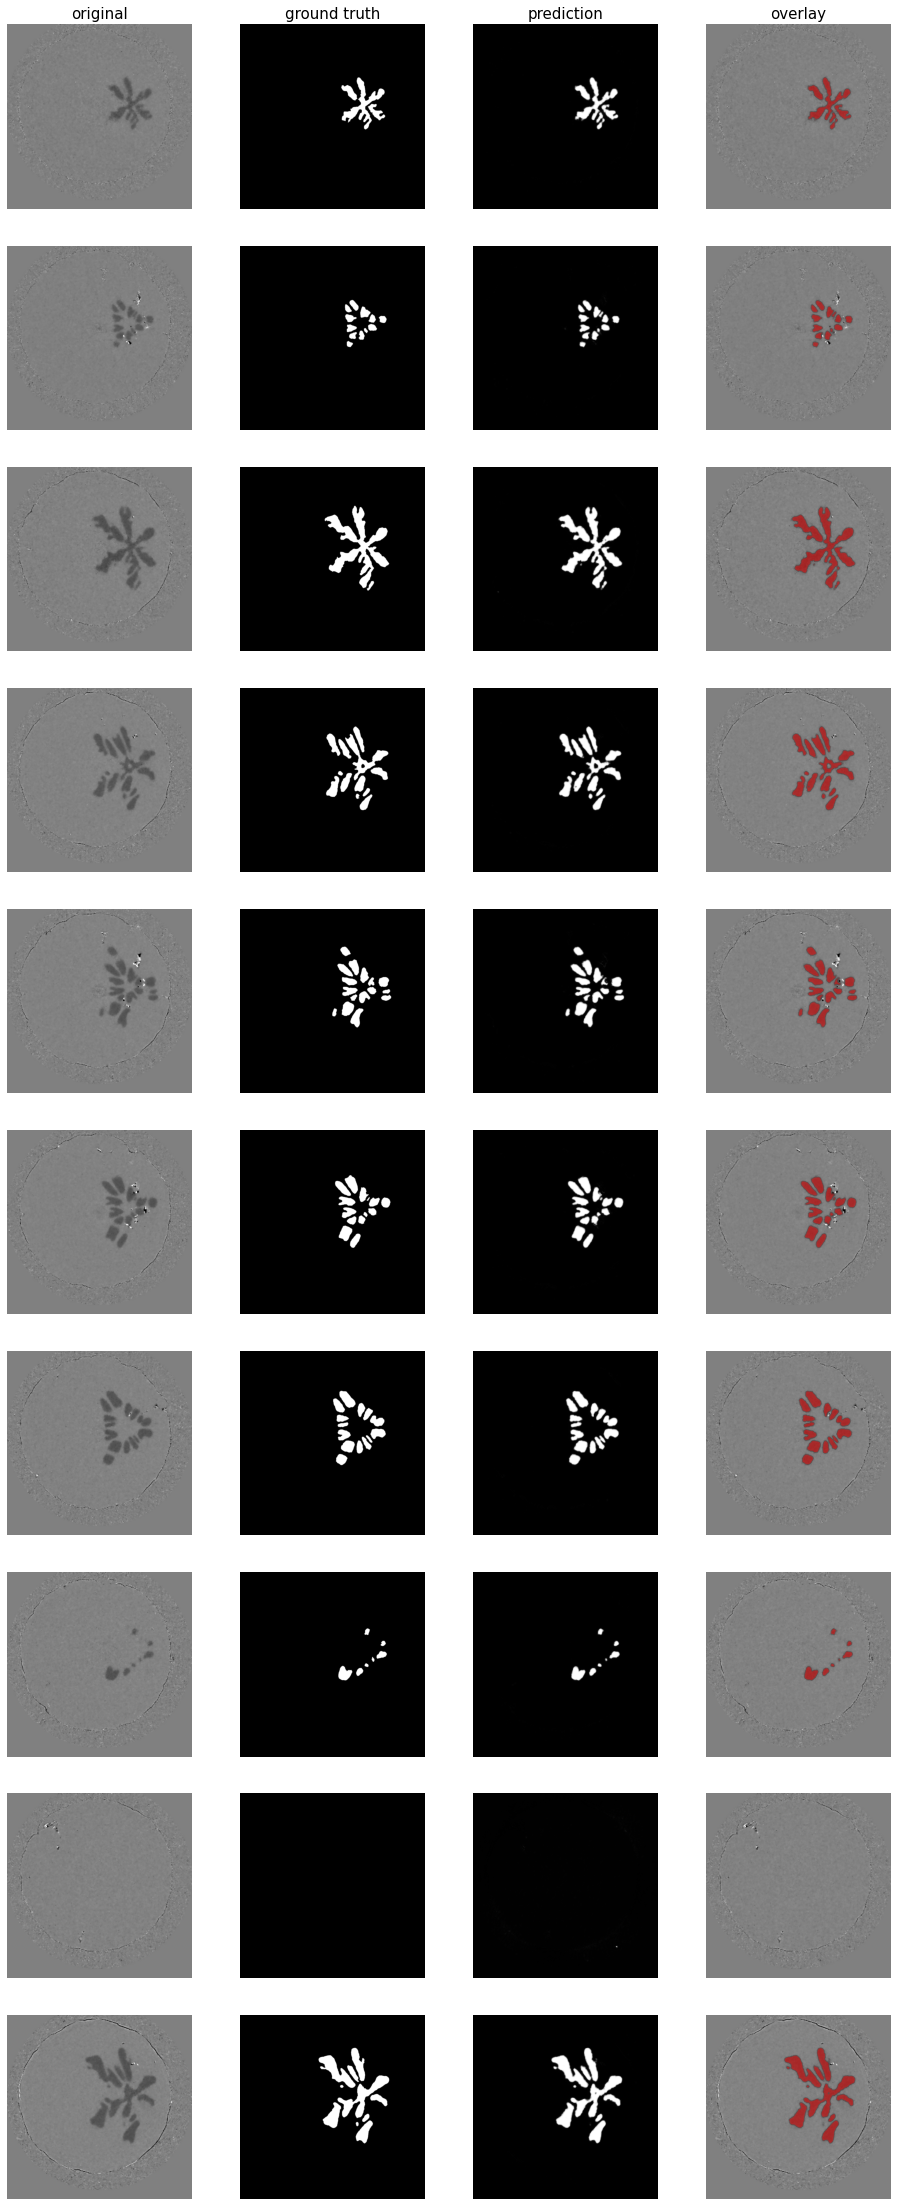

In [183]:
plot_imgs(org_imgs=X_r, mask_imgs=y_rc, pred_imgs=y_pred, nm_img_to_plot=10)



In [4]:
metadata = {
    "dc": {
        'creators': [
            {'creatorName': 'Stan, Tiberiu',
             'familyName': 'Stan',
             'givenName': 'Tiberiu'},
            {'creatorName': 'Thompson, Zach',
             'familyName': 'Thompson',
             'givenName': 'Zach'},
            {'creatorName': 'Voorhees, Peter',
             'familyName': 'Voorhees',
             'givenName': 'Peter'}
        ],
        'dates': [{'date': '2020-06-04', 'dateType': 'Accepted'}],
        'identifier': {'identifier': '10.23677/xrmb-v1rz', 'identifierType': 'DOI'},
        'publicationYear': 2020,
        'publisher': 'Materials Data Facility',
        'resourceType': {'resourceType': 'Dataset', 'resourceTypeGeneral': 'Dataset'},
        'subjects': [
            {'subject': 'machine learning'},
            {'subject': 'segmentation'},
            {'subject': 'metals and alloys'},
            {'subject': 'X-ray tomography'},
            {'subject': 'foundry'}
        ],
        'titles': [{'title': 'Semantic Segmentation of Dendrites via Machine Learning'}]
    },
    "mdf": {"source_id":"_test_foundry_stan_dendrite_segmentation_v1.1"},
    "dataset":{"inputs": ["train/input"],
    "outputs": ["train/output"],
    "input_descriptions": [],
    "output_descriptions": [],
    "type": "hdf5",
    "version": "",
    "short_name": "stan-dendrite-segmentation"
    }
}

In [5]:
import json
with open('foundry_metadata.json', 'w') as f:
    json.dump(metadata, f)